In [ ]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
# Step 1: Data Preprocessing
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/cleaned_srl_product_review.csv")
df.shape

(8260, 5)

In [ ]:
# Tokenize the reviews
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Review'])
sequences = tokenizer.texts_to_sequences(df['Review'])
print(len(sequences))
print(df['Review'][0])
print(sequences[0])
print(len(sequences),len(sequences[3]))

8260
while there may have been less noise caused by turbulence as they claim  the duct seemed to be vibrating  giving a whining sound
[195, 72, 214, 25, 145, 27, 96, 2753, 131, 4752, 16, 45, 2035, 1, 4753, 815, 6, 44, 4754, 1235, 2, 4755, 82]
8260 28


In [ ]:
# Define a ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint("model_without_duplicates.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Convert labels to categorical format
labels = {'PRED': 1, 'PROD1': 2, 'ASP': 3, 'PROD2': 4}
count = 0
labels_numbered = []
for _, row in df.iterrows():
    m_len = len(sequences[count])+2
    output_sequence = [0] * m_len
    for label, indices in eval(row['Label']).items():

        # Set the values according to the class
        for index in indices:
            output_sequence[index] = labels[label]

    labels_numbered.append(output_sequence)
    count+=1

# Pad sequences and handle null entries
max_length = 50
sequences_padded = pad_sequences(sequences, maxlen=max_length, padding='post')
labels_padded = pad_sequences(labels_numbered, maxlen=max_length, padding='post')

# Step 2: Define the LSTM Model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(units=140, dropout=0.2, recurrent_dropout=0.3, return_sequences=True))
model.add(LSTM(units=140, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(Dense(units=5, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Step 3: Training the Model
X = sequences_padded
y = labels_padded
print(X.shape,y.shape)

(8260, 50) (8260, 50)


In [ ]:
history = model.fit(X, y, epochs=15, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/15
207/207 [==============================] - ETA: 0s - loss: 0.3659 - accuracy: 0.9206
Epoch 1: val_accuracy improved from -inf to 0.92318, saving model to model_without_duplicates.h5
207/207 [==============================] - 84s 366ms/step - loss: 0.3659 - accuracy: 0.9206 - val_loss: 0.2889 - val_accuracy: 0.9232
Epoch 2/15
207/207 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.9364
Epoch 2: val_accuracy improved from 0.92318 to 0.94251, saving model to model_without_duplicates.h5
207/207 [==============================] - 66s 317ms/step - loss: 0.1979 - accuracy: 0.9364 - val_loss: 0.1652 - val_accuracy: 0.9425
Epoch 3/15
207/207 [==============================] - ETA: 0s - loss: 0.1402 - accuracy: 0.9517
Epoch 3: val_accuracy improved from 0.94251 to 0.95231, saving model to model_without_duplicates.h5
207/207 [==============================] - 69s 333ms/step - loss: 0.1402 - accuracy: 0.9517 - val_loss: 0.1367 - val_accuracy: 0.9523
Epoch 4/15
20

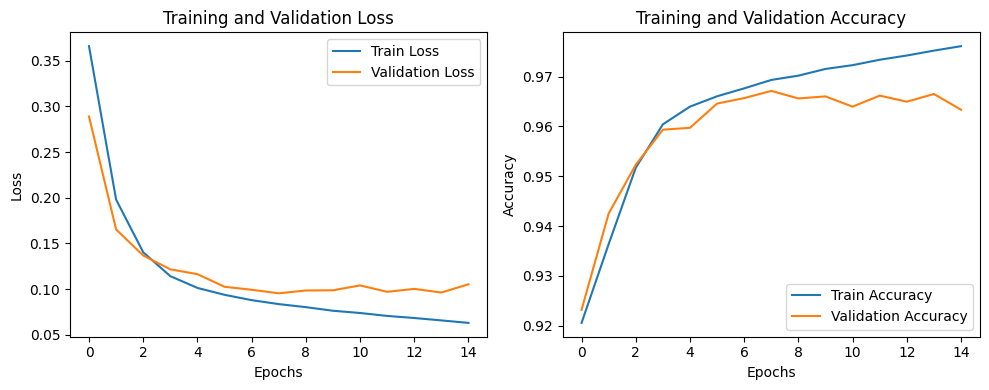

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()  # Adjusts subplot params so that the subplots fit into the figure area.
plt.show()

In [ ]:

# Step 4: Evaluation (if needed)
validation_df = pd.read_csv("/content/drive/MyDrive/cleaned_srl_product_review.csv")  # Replace "validation_data.csv" with your validation dataset file name
validation_sequences = tokenizer.texts_to_sequences(validation_df['Review'])
max_length = 50
validation_sequences_padded = pad_sequences(validation_sequences, maxlen=max_length, padding='post')

validation_labels = {'PRED': 1, 'PROD1': 2, 'ASP': 3, 'PROD2': 4}
count = 0
validation_labels_numbered = []
for _, row in validation_df.iterrows():
    # m_len = len(validation_sequences[count])+5
    m_len = len(validation_sequences_padded[count])
    output_sequence = [0] * m_len
    for label, indices in eval(row['Label']).items():
        # Set the values according to the class
        for index in indices:
            output_sequence[index] = labels[label]

    validation_labels_numbered.append(output_sequence)
    count+=1


validation_labels_padded = pad_sequences(validation_labels_numbered, maxlen=max_length, padding='post')

X_val = validation_sequences_padded
y_val = validation_labels_padded

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


259/259 [==============================] - 13s 50ms/step - loss: 0.0648 - accuracy: 0.9760
Test Loss: 0.064825139939785
Test Accuracy: 0.9759515523910522


In [ ]:
predictions = model.predict(X_val)

259/259 [==============================] - 15s 57ms/step


In [ ]:
print(X_val.shape, y_val.shape)
predictions.shape


(8260, 50) (8260, 50)


(8260, 50, 5)

In [ ]:
# Assuming `model.predict()` outputs probabilities and you need the class with the highest probability
from sklearn.metrics import classification_report

predicted_labels = np.argmax(predictions, axis=2)

true_labels = y_val # Assuming y_val is one-hot encoded

# Flatten the last two dimensions (batch size x 33 positions)
predicted_labels_flat = predicted_labels.reshape(-1)
true_labels_flat = true_labels.reshape(-1)

print(true_labels.shape, predictions.shape, predicted_labels.shape)
print(predicted_labels[0], y_val[0])
print(classification_report(true_labels_flat, predicted_labels_flat, labels=[0, 1, 2, 3, 4], target_names=['None', 'PRED', 'PROD1', 'ASP', 'PROD2']))


(8260, 50) (8260, 50, 5) (8260, 50)
[0 0 0 0 0 1 3 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0] [2 0 0 0 1 1 3 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
              precision    recall  f1-score   support

        None       0.99      0.99      0.99    381125
        PRED       0.82      0.79      0.81     10656
       PROD1       0.81      0.72      0.76      7545
         ASP       0.86      0.89      0.87      8520
       PROD2       0.94      0.88      0.91      5154

    accuracy                           0.98    413000
   macro avg       0.88      0.85      0.87    413000
weighted avg       0.98      0.98      0.98    413000



In [ ]:
##################################################################################################################
# Step 5: Prediction
# Load the saved model
from keras.models import load_model

# Load the saved model
loaded_model = load_model("model_without_duplicates.h5")


# Example sentence to predict SRL labels
example_sentences = ["Unai Emery's side have won just two of their last five Premier League games, and remain three points off the Champions League places.", " His father was a chauffeur.",
"No leadership in removing the anti-Semites.",
"Doctors are susceptible to other diseases, such as alcoholism and addiction, so why not vaccine hesitancy",
"Its modern spacious suites exude a feeling of calm, with polished wooden floors, faintly Fifties-style furnishings and original artworks.",
"Mike Minor had another solid outing, allowing just one run and five hits in six innings but didn't figure into the decision. He struck out five and walked two. Calhoun's 10th homer of the season was the first hit Minor allowed after retiring the first six batters."
]
for example_sentence in example_sentences:
    # Tokenize the example sentence
    example_sequence = tokenizer.texts_to_sequences([example_sentence])

    # Pad the sequence to ensure it has the same length as the sequences used during training
    example_sequence_padded = pad_sequences(example_sequence, maxlen=max_length, padding='post')

    # Make prediction
    predicted_labels = np.argmax(loaded_model.predict(example_sequence_padded),axis=-1)
    # predicted_labels = loaded_model.predict(example_sequence_padded)
    print(predicted_labels)
    # print(predicted_labels.shape)

1/1 [==============================] - 1s 566ms/step
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
1/1 [==============================] - 0s 59ms/step
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
1/1 [==============================] - 0s 58ms/step
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
1/1 [==============================] - 0s 56ms/step
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
1/1 [==============================] - 0s 55ms/step
[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
1/1 [==============================] - 0s 56ms/step
[[0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  3 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [ ]:

# from datasets import Dataset, DatasetDict
from datasets import load_dataset, Dataset, DatasetDict

import sentencepiece as spm

# Load SentencePiece model
sp = spm.SentencePieceProcessor()
spz = spm.SentencePieceProcessor()
sp.load('/content/drive/MyDrive/smp_en.model')
spz.load('/content/drive/MyDrive/smp_zu.model')

# Display some vocabulary items
print("Vocabulary Sample english:")
for id in range(10):  # Just show first 10 entries
    print(id, sp.id_to_piece(id))

print("Vocabulary Sample zulu:")
for id in range(10):  # Just show first 10 entries
    print(id, spz.id_to_piece(id))

# Example sentence
sentence = "No leadership in removing the anti-Semites."
sentence_zu = "Abukho ubuholi obungasusa abaphikisana nama-Semites."
# Tokenize the sentence
tokens = sp.encode_as_pieces(sentence)
print("Tokens english:", tokens)

tokens_zu = spz.encode_as_pieces(sentence_zu)
print("Tokens zulu:", tokens_zu)

# Get token IDs
token_ids = sp.encode_as_ids(sentence)
print("Token IDs English:", token_ids)

token_ids_zu = spz.encode_as_ids(sentence_zu)
print("Token IDs Zulu:", token_ids_zu)

import sentencepiece as spm

# Load SentencePiece model
sp = spm.SentencePieceProcessor()
spz = spm.SentencePieceProcessor()
sp.load('/content/drive/MyDrive/smp_en.model')
spz.load('/content/drive/MyDrive/smp_zu.model')

# Display some vocabulary items
print("Vocabulary Sample english:")
for id in range(10):  # Just show first 10 entries
    print(id, sp.id_to_piece(id))

print("Vocabulary Sample zulu:")
for id in range(10):  # Just show first 10 entries
    print(id, spz.id_to_piece(id))

# Example sentence
sentence = "Doctors are susceptible to other diseases, such as alcoholism and addiction"
sentence_zu = "Abukho ubuholi obungasusa abaphikisana nama-Semites."
# Tokenize the sentence
tokens = sp.encode_as_pieces(sentence)
print("Tokens english:", tokens)

tokens_zu = spz.encode_as_pieces(sentence_zu)
print("Tokens zulu:", tokens_zu)

# Get token IDs
token_ids = sp.encode_as_ids(sentence)
print("Token IDs English:", token_ids)

token_ids_zu = spz.encode_as_ids(sentence_zu)
print("Token IDs Zulu:", token_ids_zu)


In [2]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import load_model
import tensorflow as tf
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

In [3]:
# Remove numbers from text
def remove_numbers(text):
    return re.sub(r'\d+', '', text)
def remove_unusual_characters(text):
    res = re.sub(r'[^\w\s,.;:!?\-]','',text)
    res = re.sub(r'\.+',' ',res)
    res = re.sub(r'!+','',res)
    res = re.sub(r',+',' ',res)
    res = re.sub(r';+',' ',res)
    res = re.sub(r';+',' ',res)
    res = re.sub(r'\n+','',res)
    res = re.sub(r'\d+','',res)
    return re.sub(r'\s+', ' ', res)



    return res
def convert_to_lowercase(text):
    return text.lower()

In [3]:
df2['text'] = df2['text'].apply(remove_numbers)
df2['text']=df2['text'].apply(remove_unusual_characters)
df2['text']=df2['text'].apply(convert_to_lowercase)